In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from scipy.special import expit
import pymc3 as pm
import arviz as az

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_feasible, init_to_median, init_to_sample, \
    init_to_uniform, init_to_value

from pymc3.gp.util import plot_gp_dist

In [2]:
# Don't sting my eyes
%config InlineBackend.figure_format = 'retina'
sns.set()

# Data

Data accessible here: https://zenodo.org/record/845873#.WeDg9GhSw2x

In [3]:
df = pd.read_csv("data/cpc2018.csv")

In [8]:
data = df[(df.LotNumB == 1) & (df.LotNumA == 1) & (df.Amb == 0) 
          & (df.Ha >= 0) & (df.Hb >= 0) & (df.La >= 0) & (df.Lb >= 0)]  # & (df.La ==0)  & (df.Lb == 0)

In [9]:
data = pd.DataFrame({
    "subject": data.SubjID,
    "pA": data.pHa.values,
    "xA0": data.Ha.values,
    "xA1": data.La.values,
    "pB": data.pHb.values,
    "xB0": data.Hb.values,
    "xB1": data.Lb.values,
    "y": data.B.values
})
max_x = np.max(np.concatenate((data.xA0, data.xA1, data.xB0, data.xB1)))
data.xA0, data.xA1, data.xB0, data.xB1 = data.xA0/max_x, data.xA1/max_x, data.xB0/max_x, data.xB1/max_x

In [10]:
data

,subject,pA,xA0,xA1,pB,xB0,xB1,y
25,10100,1.0,0.019802,0.019802,0.5,0.029703,0.009901,0
26,10100,1.0,0.019802,0.019802,0.5,0.029703,0.009901,0
27,10100,1.0,0.019802,0.019802,0.5,0.029703,0.009901,0
28,10100,1.0,0.019802,0.019802,0.5,0.029703,0.009901,0
29,10100,1.0,0.019802,0.019802,0.5,0.029703,0.009901,0
...,...,...,...,...,...,...,...,...
510395,71109,1.0,0.188119,0.188119,0.1,0.960396,0.049505,0
510396,71109,1.0,0.188119,0.188119,0.1,0.960396,0.049505,0
510397,71109,1.0,0.188119,0.188119,0.1,0.960396,0.049505,0
510398,71109,1.0,0.188119,0.188119,0.1,0.960396,0.049505,0


In [81]:
print(sorted(data.pA.unique()))
print(sorted(data.pB.unique()))

print(sorted(data.xA0.unique()))

print(sorted(data.xA1.unique()))

print(sorted(data.xB0.unique()))

print(sorted(data.xB1.unique()))

[0.01, 0.1, 0.25, 0.5, 0.6, 0.95, 1.0]
[0.01, 0.05, 0.1, 0.2, 0.25, 0.4, 0.5, 0.6, 0.75, 0.8, 0.9, 0.95, 1.0]
[0.009900990099009901, 0.019801980198019802, 0.0297029702970297, 0.0594059405940594, 0.06930693069306931, 0.0891089108910891, 0.09900990099009901, 0.12871287128712872, 0.13861386138613863, 0.1485148514851485, 0.15841584158415842, 0.16831683168316833, 0.1782178217821782, 0.18811881188118812, 0.19801980198019803, 0.22772277227722773, 0.2376237623762376, 0.24752475247524752, 0.27722772277227725, 0.297029702970297, 0.31683168316831684, 0.38613861386138615, 0.504950495049505, 0.5247524752475248, 0.594059405940594, 0.8415841584158416]
[0.0, 0.009900990099009901, 0.019801980198019802, 0.0297029702970297, 0.039603960396039604, 0.06930693069306931, 0.0891089108910891, 0.09900990099009901, 0.12871287128712872, 0.13861386138613863, 0.15841584158415842, 0.16831683168316833, 0.1782178217821782, 0.18811881188118812, 0.19801980198019803, 0.2079207920792079, 0.22772277227722773, 0.237623762376

# CPT fit

In [58]:
def u_pow(x, theta): return x**theta

def u_exp(x, theta): return 1 - np.exp(-theta*x) if isinstance(x, np.ndarray) else 1 - jnp.exp(-theta*x)

def lin(x, theta): return x

def prelec(p, theta): return np.exp(-(-np.log(p))**theta) if isinstance(p, np.ndarray) else jnp.exp(-(-jnp.log(p))**theta)

In [82]:
def softplus(x):
    return np.log(np.exp(x) + 1)

def objective(data, u, w):
    
    pA = data.pA.values
    pB = data.pB.values

    xA0 = data.xA0.values
    xA1 = data.xA1.values

    xB0 = data.xB0.values
    xB1 = data.xB1.values

    y = data.y.values 
    
    def run(param):
        
        tau = softplus(param[0])
        theta_u = softplus(param[1])
        
        if w is not None:
            theta_w = expit(param[2])
            wpA = w(pA, theta_w)
            wpB = w(pB, theta_w)
        
        else:
            wpA = pA
            wpB = pB
        
        uxA0 = u(xA0, theta_u)
        uxA1 = u(xA1, theta_u)
        uxB0 = u(xB0, theta_u)
        uxB1 = u(xB1, theta_u)

        seuA = wpA * uxA0 + (1-wpA) * uxA1
        seuB = wpB * uxB0 + (1-wpB) * uxB1

        diff_seu = seuB - seuA

        p_choice_B = scipy.special.expit(tau*diff_seu)
        p_choice_y = p_choice_B**y * (1-p_choice_B)**(1-y)

        lls = np.log(p_choice_y + np.finfo(float).eps).sum()
        return - lls
    return run

def optimize(data, u=u_pow, w=None, seed=12345):
    np.random.seed(seed)
    if w is None:
        opt = scipy.optimize.minimize(objective(data, u, w), x0=np.ones(2))
        theta_w = None
    else:
        opt = scipy.optimize.minimize(objective(data, u, w), x0=np.ones(3))
        theta_w = expit(opt.x[2])
        
    tau = softplus(opt.x[0])
    theta_u = softplus(opt.x[1])
    return tau, theta_u, theta_w

In [83]:
optimize(data)

(26.720759439803953, 0.8174693045702498, None)

# Model discrepancy

In [98]:
def kernel(X, Xs, length):
    deltaX = jnp.power((X[:, None] - Xs) / length, 2.0)
    return jnp.exp(-0.5 * deltaX)

In [118]:
def sparse_model(X, y, p, init_order, u, theta_u, tau, T, jitter=1e-06):
    
    n = y.shape[0]
    
    var = numpyro.sample("kernel_var", dist.TruncatedNormal(low=0., loc=1., scale=1.))
    length = numpyro.sample("kernel_length", dist.TruncatedNormal(low=0., loc=1., scale=1.))
    
    with numpyro.plate("T", T):
        Xt = numpyro.sample("Xtrain", dist.Uniform(low=0, high=1))
        eta = numpyro.sample('eta', dist.Normal())
        
    Mt = jnp.asarray(u(Xt, theta_u))
    K_factor = Mt[:, None] * Mt
    
    k_XX = K_factor * var **2 * kernel(Xt, Xt, length) + jitter*jnp.eye(T)
    L = jnp.linalg.cholesky(k_XX)
    L_dot_eta = jnp.dot(L, eta)
    # f = Mt + L_dot_eta

    Mp = jnp.asarray(u(X, theta_u))
    K_Xp_factor = Mt[:, None] * Mp
    
    K_Xp = K_Xp_factor * var**2 * kernel(Xt, X, length)
    A = jax.scipy.linalg.solve_triangular(L, K_Xp, lower=True)
    v = jax.scipy.linalg.solve_triangular(L, L_dot_eta, lower=True)

    f_predict = numpyro.deterministic("f", Mp + A.T.dot(v))
    
    est_eu_sorted =  p * f_predict    
    est_eu = est_eu_sorted[init_order].reshape((4, n))
    est_eu_A = est_eu[0] + est_eu[1]
    est_eu_B = est_eu[2] + est_eu[3]
    
    # est_u =  f_predict[init_order].reshape((4, n))    
    # est_eu_A = w_pA*est_u[0] + (1-w_pA)*est_u[1]
    # est_eu_B = w_pB*est_u[2] + (1-w_pB)*est_u[3]

    est_diff_eu = est_eu_B - est_eu_A
    
    numpyro.sample("obs", dist.Bernoulli(logits=tau * est_diff_eu), obs=y)

In [119]:
def run_inference_sparse(data, u, theta_u, tau, T):
    
    pA = data.pA.values
    pB = data.pB.values

    xA0 = data.xA0.values
    xA1 = data.xA1.values

    xB0 = data.xB0.values
    xB1 = data.xB1.values

    y = data.y.values 

    n = len(y)

    x = np.hstack((xA0, xA1, xB0, xB1))
    x_order = np.argsort(x)
    x_sorted = x[x_order]
    init_order = np.argsort(x_order)

    X = jnp.array(x_sorted)

    # w_pA = jnp.array(w(pA, theta_w))
    # w_pB = jnp.array(w(pB, theta_w))
    p = np.hstack((pA, 1-pA, pB, 1-pB))
    p = jnp.array(p[x_order])
    
    y = jnp.array(y)
    
    rng_key = random.PRNGKey(123)

    nuts = MCMC(NUTS(sparse_model, target_accept_prob=0.9, max_tree_depth=10, 
                     init_strategy=init_to_uniform(radius=2)),
                     num_samples=1000, num_warmup=1000)
    nuts.run(rng_key, X=X, y=y, p=p, init_order=init_order, 
             u=u, theta_u=theta_u, tau=tau, T=T)
    return X, nuts

In [120]:
np.random.seed(1234)
data_gp = data.sample(200)
u = u_pow
w = None # prelec

opt_param = optimize(data_gp, u=u, w=w)
tau = opt_param[0]
theta_u = opt_param[1]
theta_w = opt_param[2]
print(f"tau={tau}, theta_u={theta_u}", f"theta_w={theta_w}")

tau=34.44655122208853, theta_u=0.8822211886515096 theta_w=None


In [121]:
X, nuts = run_inference_sparse(
    data=data_gp, T=50,
    u=u, theta_u=theta_u, tau=tau)

sample: 100%|██████████| 2000/2000 [03:32<00:00,  9.41it/s, 127 steps of size 3.77e-02. acc. prob=0.86]


In [122]:
nuts.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      Xtrain[0]      0.49      0.29      0.47      0.01      0.90    513.98      1.00
      Xtrain[1]      0.52      0.28      0.54      0.13      1.00    532.22      1.00
      Xtrain[2]      0.50      0.30      0.51      0.00      0.91    311.03      1.00
      Xtrain[3]      0.51      0.28      0.51      0.09      0.98    440.66      1.00
      Xtrain[4]      0.48      0.29      0.47      0.05      0.95    454.44      1.00
      Xtrain[5]      0.50      0.28      0.51      0.04      0.92    769.97      1.00
      Xtrain[6]      0.49      0.28      0.46      0.11      1.00    652.96      1.00
      Xtrain[7]      0.48      0.31      0.47      0.00      0.91    363.33      1.00
      Xtrain[8]      0.49      0.30      0.48      0.01      0.92    390.87      1.00
      Xtrain[9]      0.49      0.28      0.47      0.01      0.89    847.28      1.00
     Xtrain[10]      0.51      0.28      0.52      0.

In [130]:
f_samples = nuts.get_samples()["f"]

In [131]:
uX = u(X, theta_u)

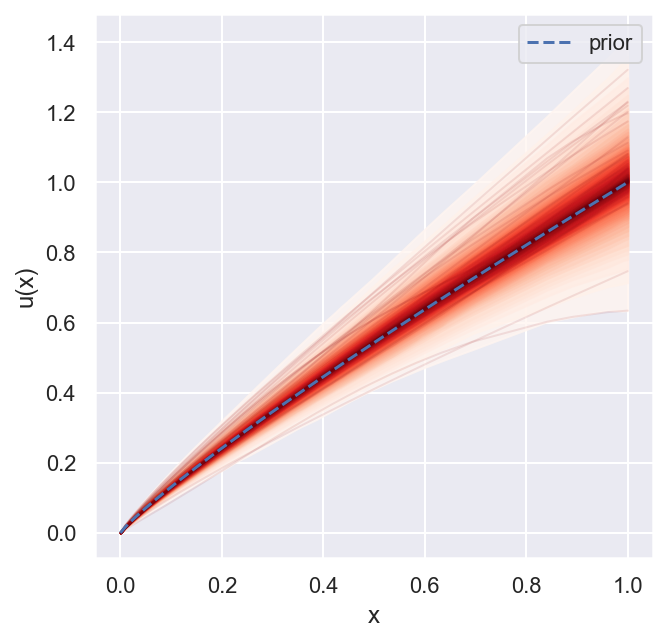

In [157]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_gp_dist(ax, f_samples, X)
ax.plot(X, uX, ls='--', color='C0', label="prior")
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.legend();

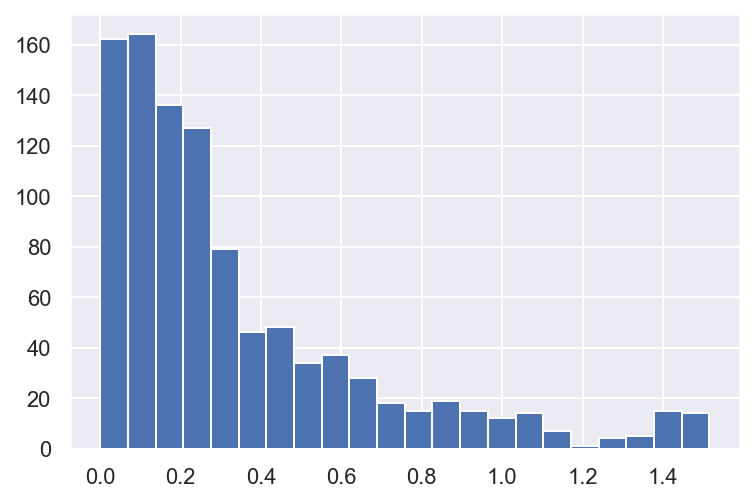

In [159]:
plt.hist(nuts.get_samples()["kernel_var"], bins='auto');

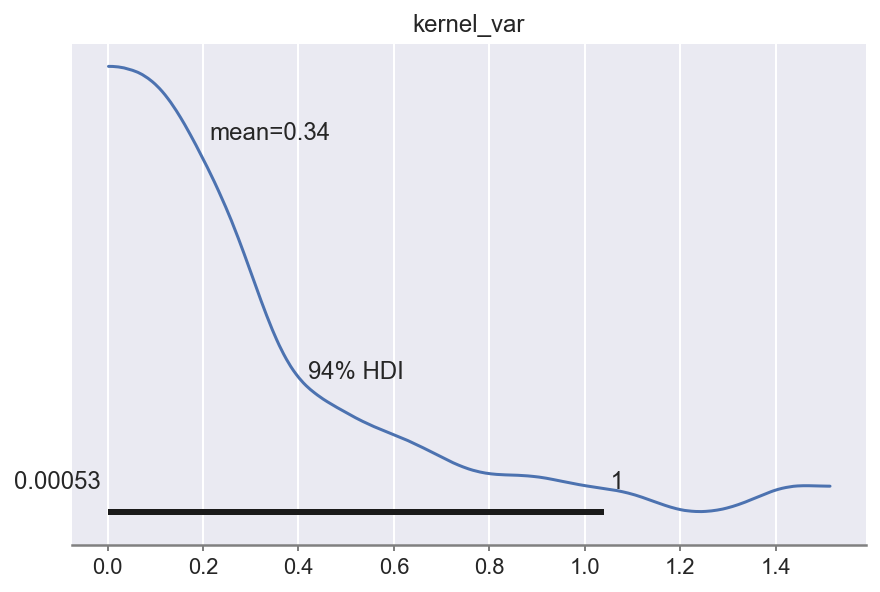

In [167]:
az.plot_posterior({"kernel_var": np.asarray(nuts.get_samples()["kernel_var"])}, var_names=["kernel_var", ]);

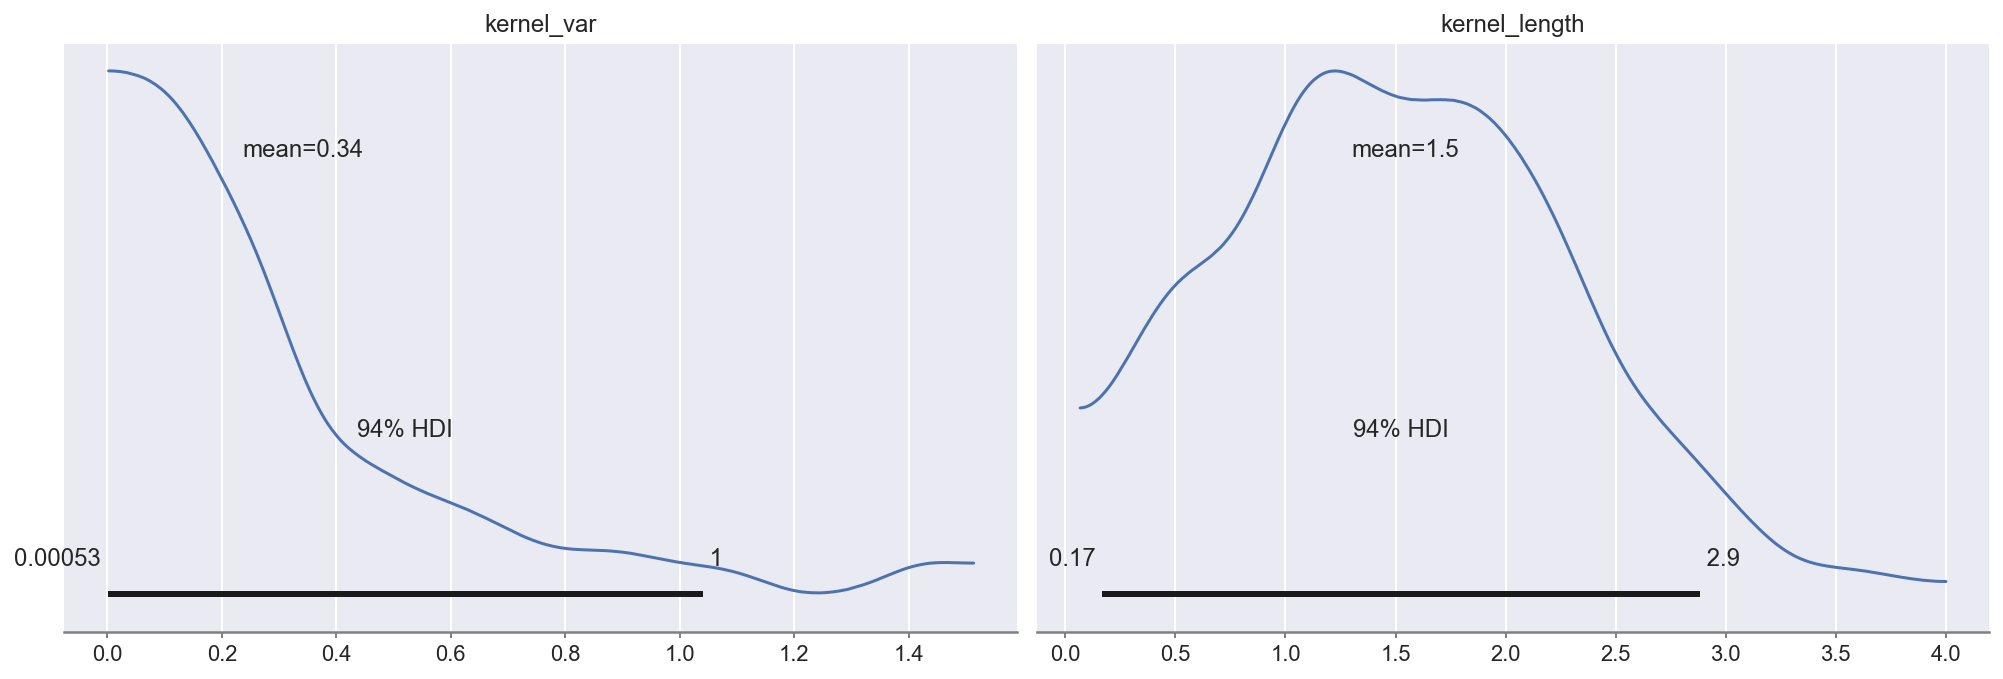

In [134]:
az_samples = az.from_numpyro(nuts)
az.plot_posterior(az_samples, var_names=['kernel_var', 'kernel_length']);

In [136]:
r = (f_samples+1e-06) / (uX + 1e-06)

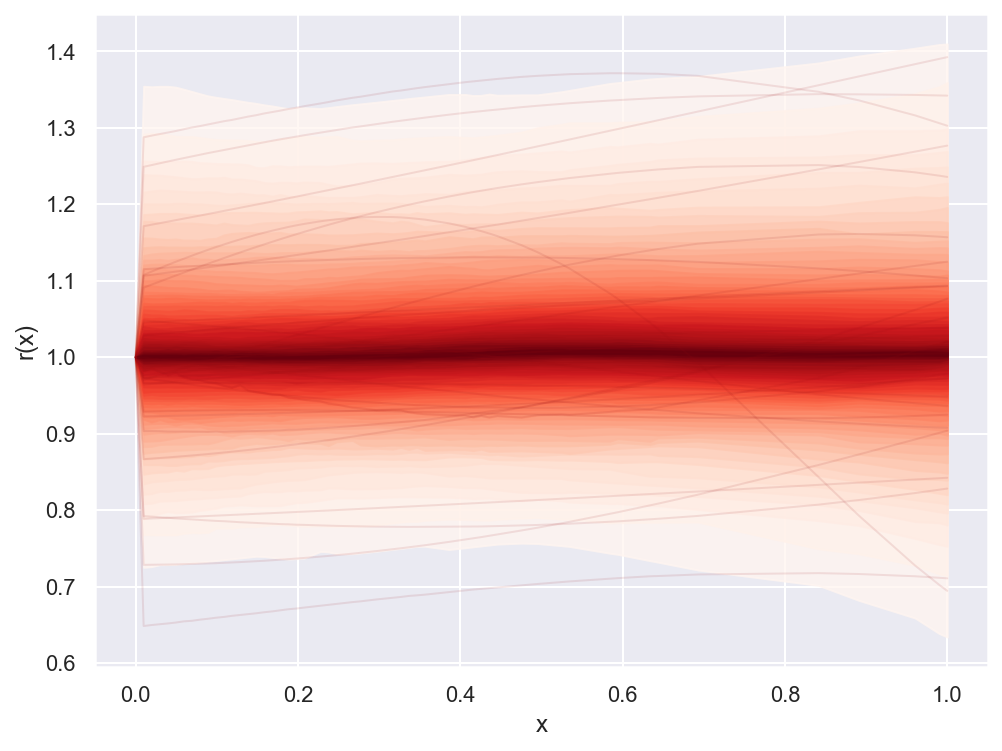

In [137]:
fig, ax = plt.subplots(figsize=(8, 6))
pm.gp.util.plot_gp_dist(ax, r, X)
ax.set_xlabel("x")
ax.set_ylabel("r(x)");

# Individual fit

In [140]:
n_per_subject = data.subject.value_counts()

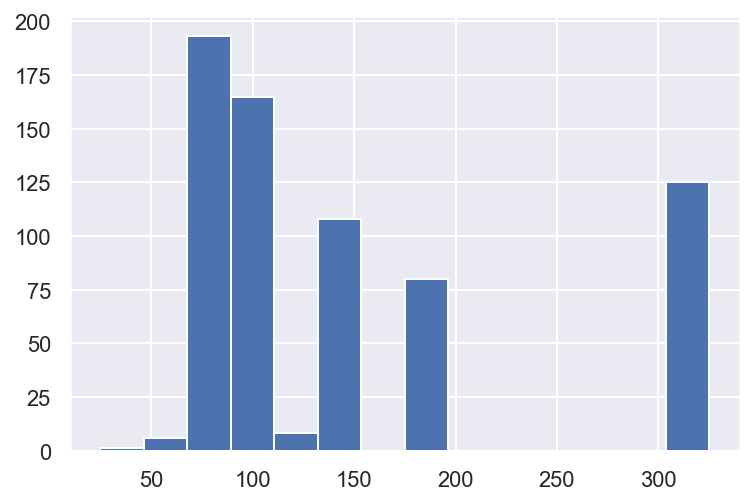

In [142]:
plt.hist(n_per_subject, bins='auto');

In [147]:
counts = data.subject.value_counts()
subject_325 =  counts[counts == 325].index
print(subject_325)

Int64Index([11303, 10113, 10316, 11603, 11020, 11315, 11309, 11027, 10355,
            10342,
            ...
            10107, 11322, 11328, 11007, 11008, 11002, 11327, 10104, 10116,
            11302],
           dtype='int64', length=125)


sample: 100%|██████████| 2000/2000 [21:37<00:00,  1.54it/s, 1023 steps of size 1.64e-04. acc. prob=0.97]


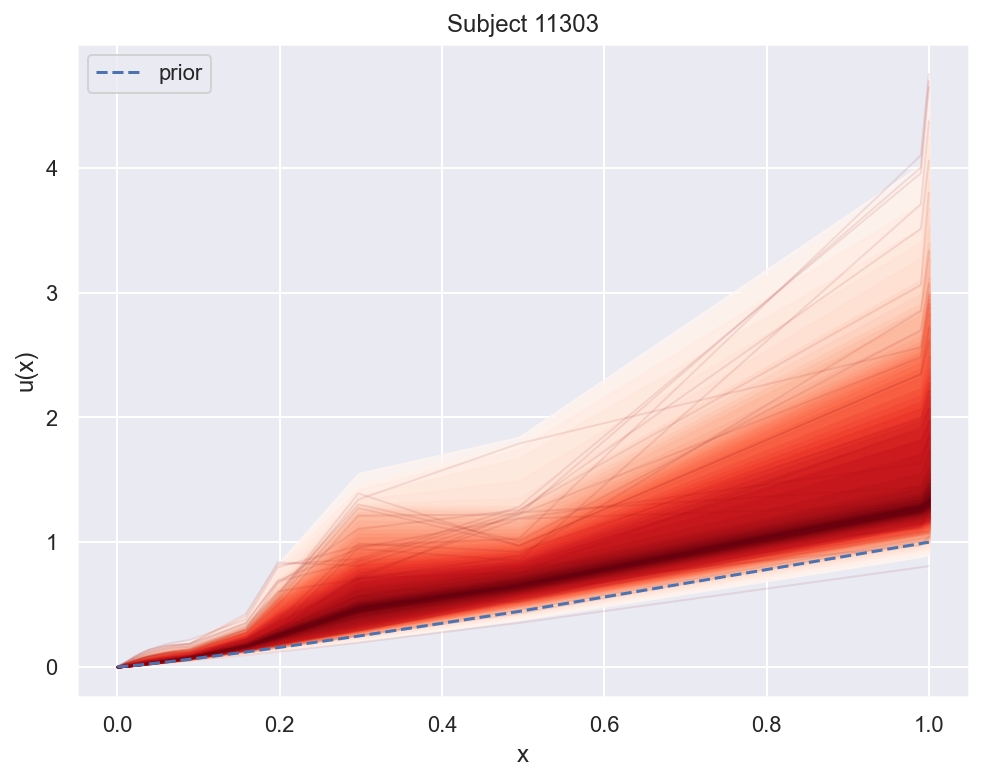

warmup:  16%|█▌        | 315/2000 [01:24<06:18,  4.45it/s, 131 steps of size 1.55e-06. acc. prob=0.87] 

In [ ]:
r = []

for s in subject_325:
    d = data[data.subject == s]
    opt_param = optimize(d, u=u_pow, w=None)
    tau = opt_param[0]
    theta_u = opt_param[1]
    theta_w = opt_param[2]
    X, nuts = run_inference_sparse(data=d, u=u_pow, theta_u=theta_u, tau=tau, T=50)
    samples = nuts.get_samples() 
    f_samples = np.asarray(samples["f"])
    uX = u(X, theta_u)
    r.append(dict(
        subject=s,
        theta_u=theta_u,
        tau=tau,
        var=np.asarray(samples["kernel_var"]),
        length=np.asarray(samples["kernel_length"]),
        eta=np.asarray(samples["eta"]),
        Xtrain=np.asarray(samples["Xtrain"]),
        x=np.asarray(X),
        f=f_samples,
    ))
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f"Subject {s}")
    plot_gp_dist(ax, f_samples, X)
    ax.plot(X, uX, ls='--', color='C0', label="prior")
    ax.set_xlabel("x")
    ax.set_ylabel("u(x)")
    ax.legend()
    plt.show()